In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 		#to normalize data
from sklearn.metrics import mean_absolute_error                 #to evaluate the results
from custom_objects import LSTMModel, smape

In [3]:
# Standard scalar normalization
def normalize_data(df, model):
    cols_normalize = df.columns.difference(['id','time_cycles','RUL'])
    norm_df = pd.DataFrame(model.scaler.transform(df[cols_normalize]),
                             columns=cols_normalize,
                             index=df.index)
    join_df = df[df.columns.difference(cols_normalize)].join(norm_df)
    df = join_df.reindex(columns = df.columns)
    return df
        
# Data ETL
def etl(df_path, model):
    index_names = ['id', 'time_cycles']
    setting_names = ['setting_1', 'setting_2', 'setting_3']
    sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
    col_names = index_names + setting_names + sensor_names
    try:
        #df = pd.read_csv(df_path,sep='\s+',header=None,index_col=False,names=col_names)
        df = pd.read_csv(df_path, sep=',')
    except:
        print("No file was found or it's structure is not as expected")
        
    df = df.sort_values(['id','time_cycles'])
    #ids = [20, 31, 34, 35, 36, 66, 68, 76, 81, 100]
    #df = df[df['id'].isin(ids)]
    
    # drop the constants features and the settings based on the EDA
    list_columns_droped = ['setting_1', 'setting_2', 'setting_3', 's_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
    df.drop(columns=list_columns_droped, inplace=True)
        
    # data normalization
    # it needs to use the saved model
    df = normalize_data(df, model)
        
    print("ETL completed!")
    return df
    
# Production real RUL
def pred_RUL(df):
    y_true = pd.read_csv('../dataset/CMaps/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    ids = [20, 31, 34, 35, 36, 66, 68, 76, 81, 100]
    
    idx = [x - 1 for x in ids]
    y_true = y_true['RUL'].iloc[idx].tolist()
    
    m = df.groupby('id')['time_cycles'].max()
    r = [x + y for x, y in zip(m.tolist(), y_true)]

    rul = pd.DataFrame({'id': ids,'max': r,}).reset_index(drop=True)
    df = df.merge(rul, on=['id'], how='left')
    df['RUL'] = df['max'] - df['time_cycles']
    df.drop('max', axis=1, inplace=True)
    return df
    
def report(y_true, y_pred): 
    thr = 30  # RUL threshold for evaluation
    inputs = (y_pred <= thr, y_true <= thr)
    idx = np.any(inputs, axis=0)
    y_pred = y_pred[idx]
    y_true = y_true[idx]
    return (mean_absolute_error(y_true, y_pred), np.std(np.abs(y_true - y_pred)))

In [4]:
model_path = '../trained_models/lstm_pipeline_w5_v2_2024-06-08_15_56_34.pkl'
test_path  = '../dataset/test_set.csv'

with open(model_path, 'rb') as file:
    lstm_model = pickle.load(file)

df_test = etl(test_path, lstm_model)
df_test  = pred_RUL(df_test)

x_test =np.concatenate(list(list(lstm_model.get_window(df_test[df_test['id']==unit], lstm_model.window, lstm_model.features)) 
                            for unit in df_test['id'].unique()))
y_test =np.concatenate(list(list(lstm_model.gen_target(df_test[df_test['id']==unit], lstm_model.window, "RUL")) 
                            for unit in df_test['id'].unique()))
y_pred = lstm_model.model.predict(x_test, verbose=0)

2024-06-12 14:41:18.670340: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-12 14:41:18.957241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-12 14:41:18.958965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-12 14:41:18.960058: I tensorflow/core/com

ETL completed!


2024-06-12 14:41:19.529085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-12 14:41:19.530965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-12 14:41:19.532119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [5]:
report(y_test, y_pred[:,0])

(6.102479405664093, 5.866744876982304)

In [6]:
mean_absolute_error(y_test, y_pred[:,0])

24.658275518433104

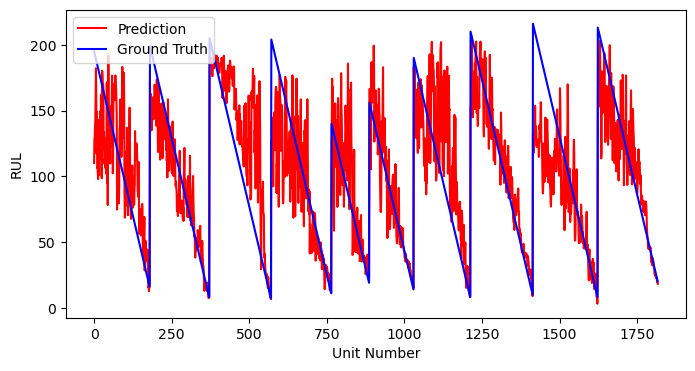

In [7]:
plt.figure(figsize=(8,4))
plt.plot(y_pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

In [8]:
y_pred = y_pred.reshape((-1,))

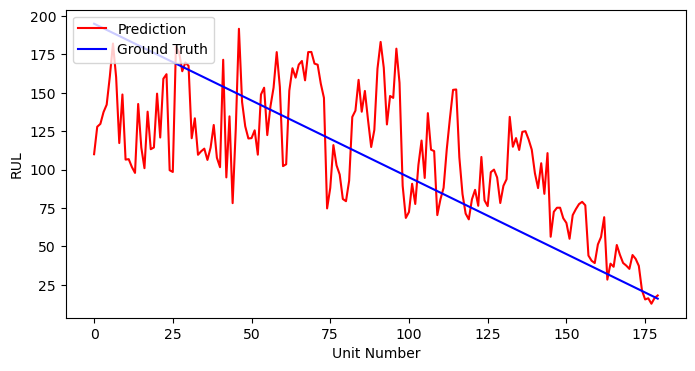

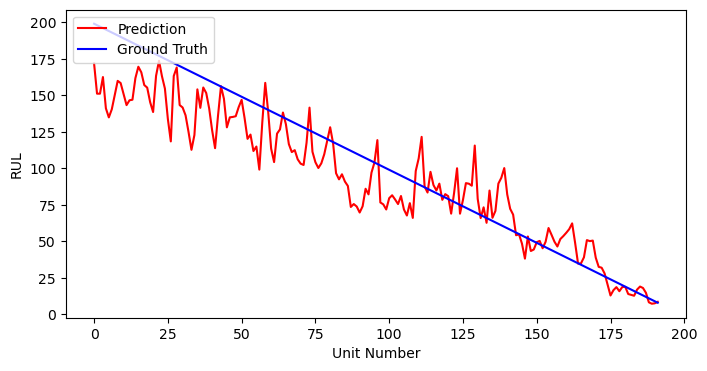

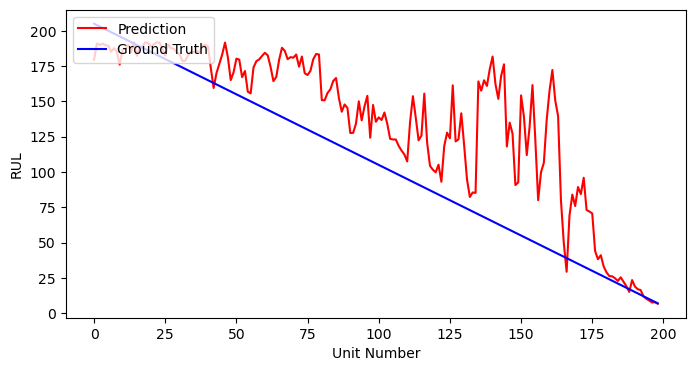

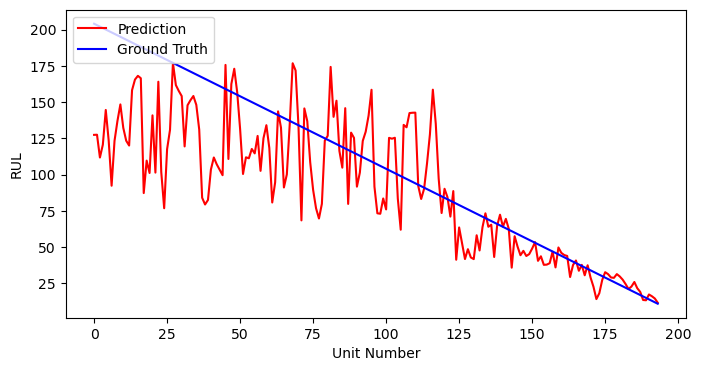

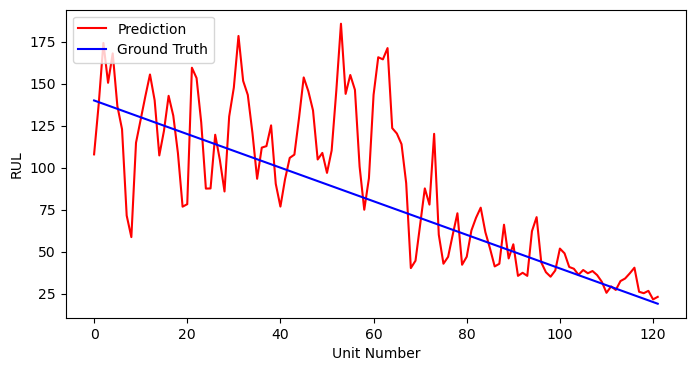

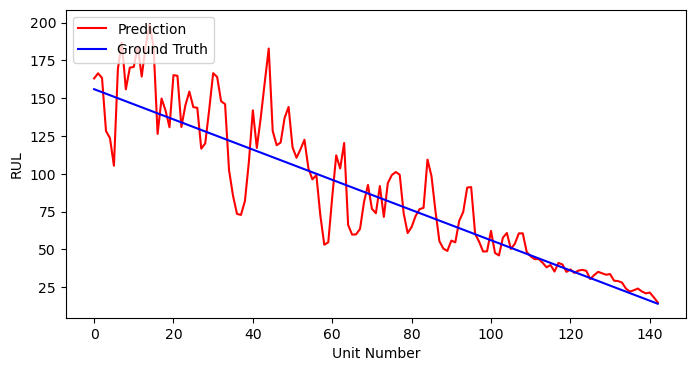

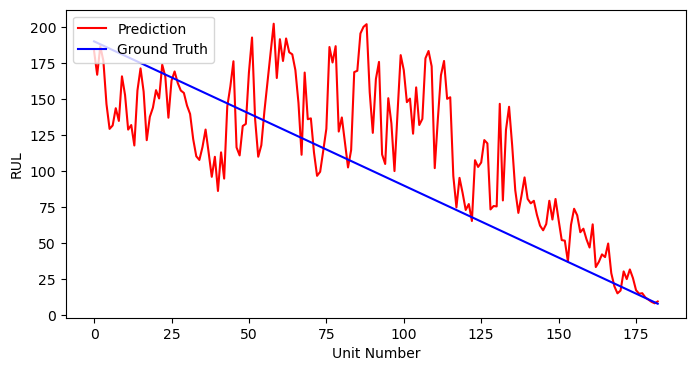

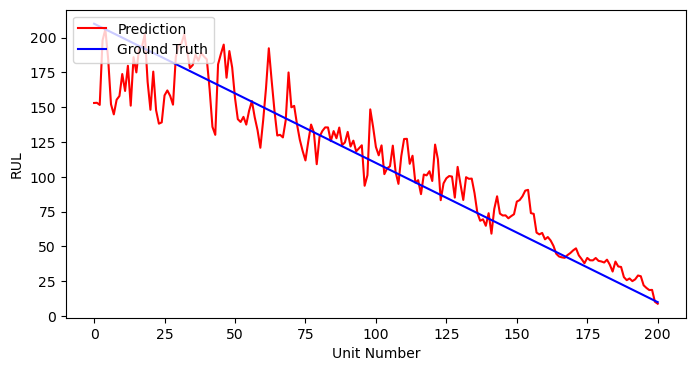

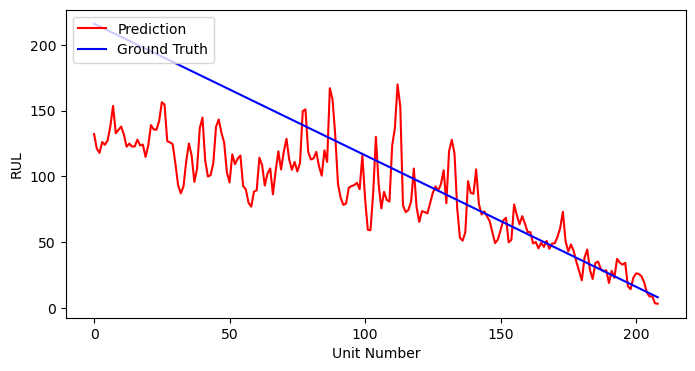

In [9]:
cont = 0
y_real = []
y_predicted = []
for i in range(1, len(y_test)):
    if y_test[i] > y_test[i-1]:
        y_real.append(y_test[cont:i])
        y_predicted.append(y_pred[cont:i])
        cont = i
for i in range(len(y_predicted)):
    plt.figure(figsize=(8,4))
    plt.plot(y_predicted[i], color='red', label='Prediction')
    plt.plot(y_real[i], color='blue', label='Ground Truth')
    plt.ylabel("RUL")
    plt.xlabel("Unit Number")
    plt.legend(loc='upper left')
    plt.show()

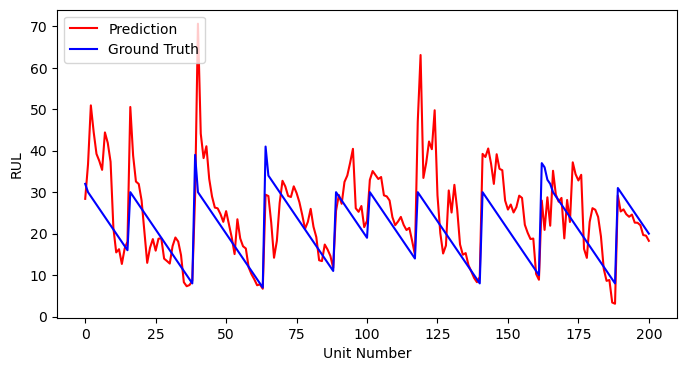

In [10]:
inputs = (y_pred <= 30, y_test <= 30)
idx = np.any(inputs, axis=0)
y_hat  = y_pred[idx]
y_true = y_test[idx]

plt.figure(figsize=(8,4))
plt.plot(y_hat, color='red', label='Prediction')
plt.plot(y_true, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

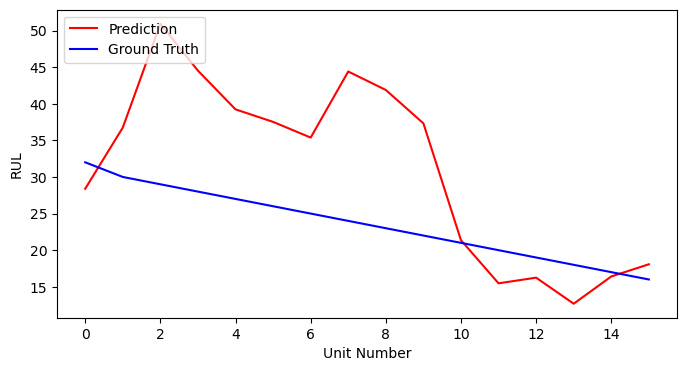

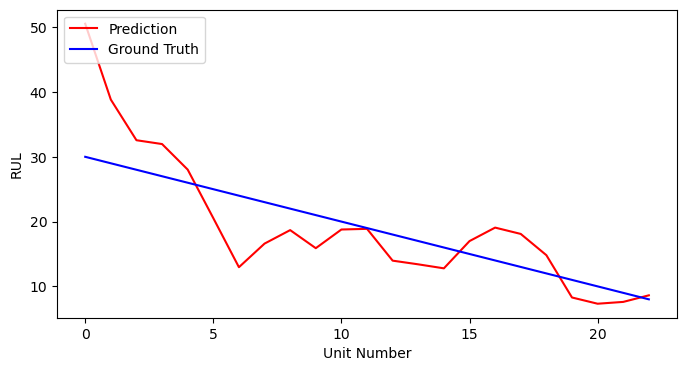

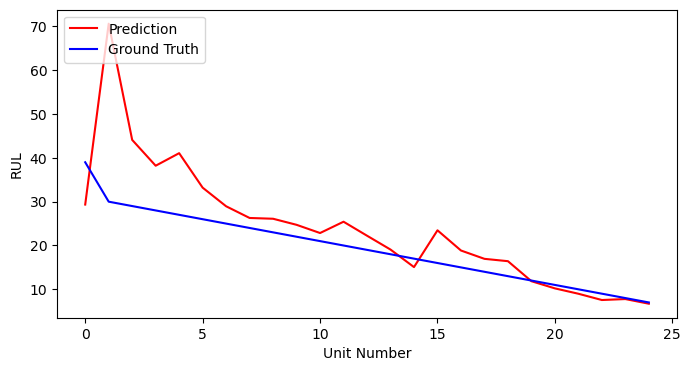

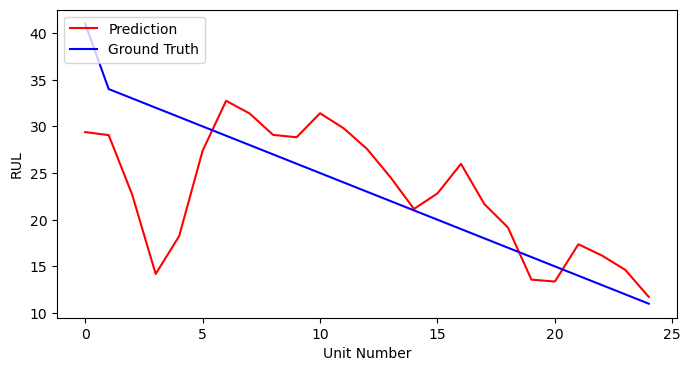

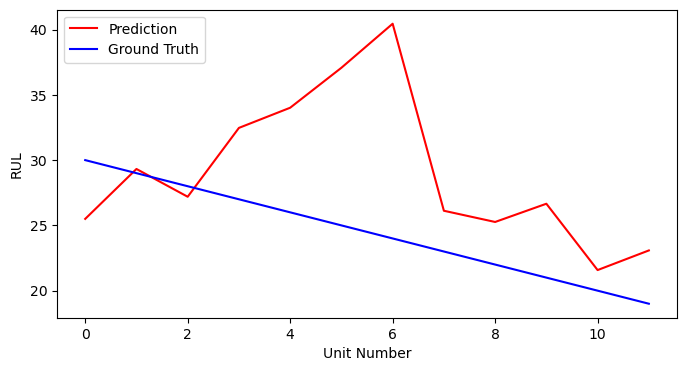

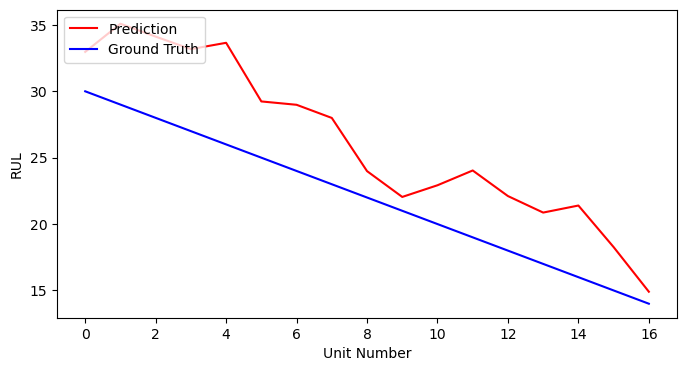

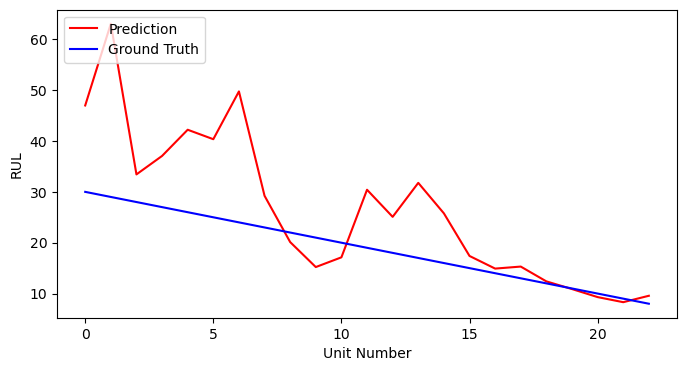

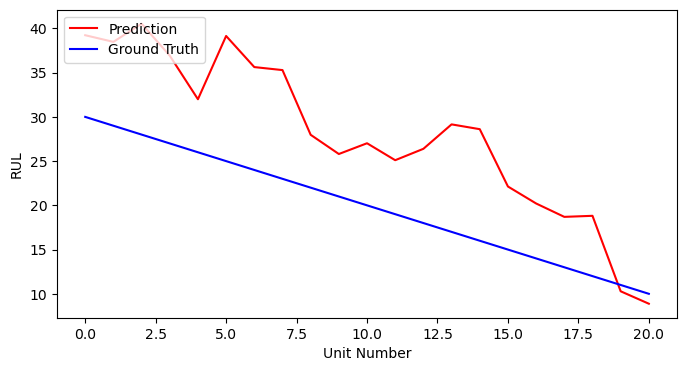

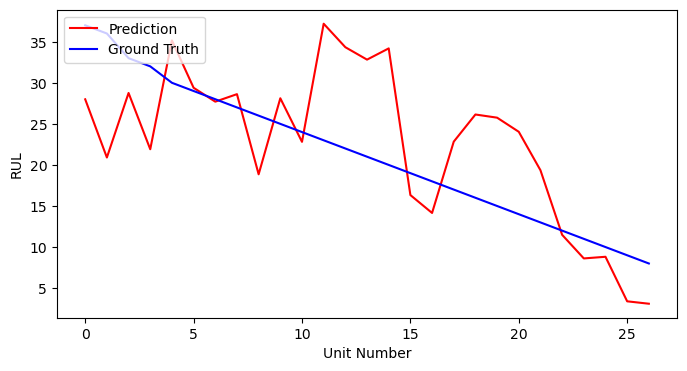

In [11]:
cont = 0
y_real = []
y_predicted = []
for i in range(1, len(y_true)):
    if y_true[i] > y_true[i-1]:
        y_real.append(y_true[cont:i])
        y_predicted.append(y_hat[cont:i])
        cont = i
for i in range(len(y_predicted)):
    plt.figure(figsize=(8,4))
    plt.plot(y_predicted[i], color='red', label='Prediction')
    plt.plot(y_real[i], color='blue', label='Ground Truth')
    plt.ylabel("RUL")
    plt.xlabel("Unit Number")
    plt.legend(loc='upper left')
    plt.show()